In [1]:
!pip install torch torchvision opencv-python scikit-learn matplotlib seaborn wandb pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import wandb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PROJECT_NAME = "PRACTICA1AA2_CLASIFICADOR_PLANTAS"
ENTITY_NAME = "adriojeda04-ayuntamiento-de-las-palmas-de-gran-canaria"
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

BASE_DATA_PATH = r'imagenes_plantas'

os.environ['WANDB_API_KEY'] = '46f614d357c93d112f9541302d26febd572f0c93'
wandb.login()

wandb: Currently logged in as: adriojeda04 (adriojeda04-ayuntamiento-de-las-palmas-de-gran-canaria) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((230, 230)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PlantDataset(Dataset):
    def __init__(self, base_dir, max_images_per_class=200):
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        if not os.path.exists(base_dir):
             raise RuntimeError(f"Error: No se encuentra el directorio {base_dir}")

        class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

        for i, class_name in enumerate(class_names):
            self.class_to_idx[class_name] = i
            class_path = os.path.join(base_dir, class_name)
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            
            for filename in files[:max_images_per_class]:
                self.image_paths.append(os.path.join(class_path, filename))
                self.labels.append(i)

        self.num_classes = len(self.class_to_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.image_paths[idx], self.labels[idx]

class ImageLoader(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        original_idx = self.subset.indices[idx]
        path, label = self.subset.dataset[original_idx]
        
        img = cv2.imread(path)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        if self.transform:
            img = self.transform(img)
            
        return img, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.subset)

full_dataset = PlantDataset(BASE_DATA_PATH)
classes = list(full_dataset.class_to_idx.keys())

train_idx, test_idx = train_test_split(
    range(len(full_dataset)), test_size=0.2, stratify=full_dataset.labels, random_state=42
)

train_ds = ImageLoader(Subset(full_dataset, train_idx), transform=train_transforms)
test_ds = ImageLoader(Subset(full_dataset, test_idx), transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Datos cargados: {len(train_ds)} entrenamiento, {len(test_ds)} test.")
print(f"Clases: {classes}")

Datos cargados: 904 entrenamiento, 226 test.
Clases: ['African Violet (Saintpaulia ionantha)', 'Aloe-Vera', 'Kalanchoe', 'Lily of the valley (Convallaria majalis)', 'Money Tree (Pachira aquatica)', 'Tulip']


In [4]:
print("Configurando arquitectura ResNet50...")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, full_dataset.num_classes)
)

model = model.to(device)
print("Modelo listo en GPU.")

Configurando arquitectura ResNet50...
Modelo listo en GPU.



Iniciando Entrenamiento (Transfer Learning)...
Epoch 1/20 | Train Loss: 1.6873 | Val Loss: 1.5445 | Val Acc: 80.09%
  >>> Nuevo récord: 80.09% (Guardado)
Epoch 2/20 | Train Loss: 1.3537 | Val Loss: 1.1041 | Val Acc: 82.74%
  >>> Nuevo récord: 82.74% (Guardado)
Epoch 3/20 | Train Loss: 0.8856 | Val Loss: 0.6647 | Val Acc: 88.05%
  >>> Nuevo récord: 88.05% (Guardado)
Epoch 4/20 | Train Loss: 0.5394 | Val Loss: 0.4071 | Val Acc: 90.71%
  >>> Nuevo récord: 90.71% (Guardado)
Epoch 5/20 | Train Loss: 0.3619 | Val Loss: 0.3174 | Val Acc: 93.81%
  >>> Nuevo récord: 93.81% (Guardado)
Epoch 6/20 | Train Loss: 0.2896 | Val Loss: 0.2480 | Val Acc: 96.46%
  >>> Nuevo récord: 96.46% (Guardado)
Epoch 7/20 | Train Loss: 0.2564 | Val Loss: 0.2085 | Val Acc: 95.13%
Epoch 8/20 | Train Loss: 0.1950 | Val Loss: 0.1700 | Val Acc: 96.46%
Epoch 9/20 | Train Loss: 0.1612 | Val Loss: 0.1527 | Val Acc: 96.46%
Epoch 10/20 | Train Loss: 0.1637 | Val Loss: 0.1529 | Val Acc: 97.35%
  >>> Nuevo récord: 97.35% (Guard

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 20/20 | Train Loss: 0.0623 | Val Loss: 0.0744 | Val Acc: 98.23%


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▇▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▄▅▆▇▇▇▇▇▇█▇▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,0.06234
val_acc,98.23009
val_loss,0.07438


Fin Transfer Learning. Mejor Accuracy: 98.67%


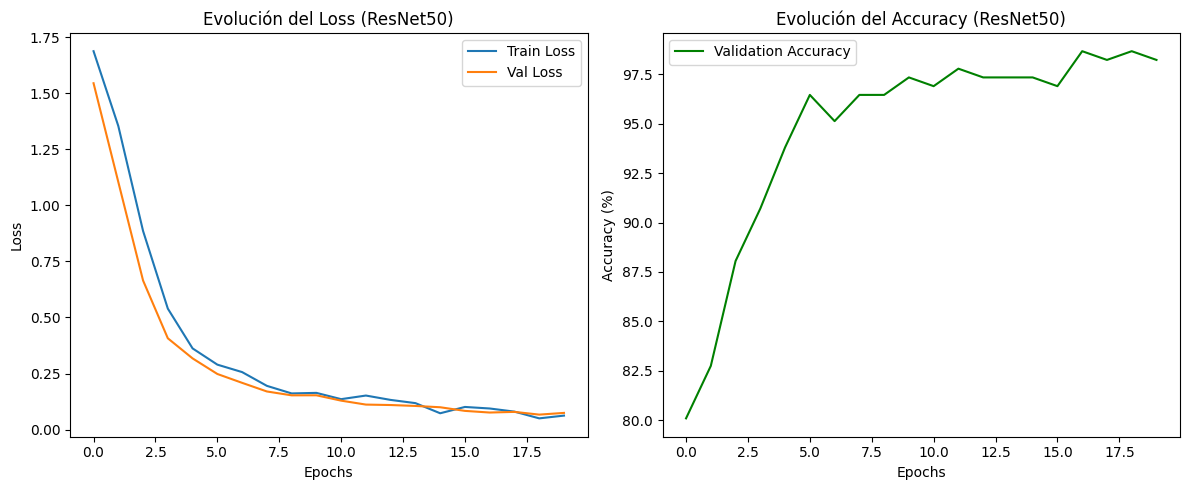

In [5]:
wandb.init(
    project=PROJECT_NAME,
    entity=ENTITY_NAME,
    config={
        "model": "ResNet50",
        "strategy": "Deep Fine-Tuning (Layer4)",
        "epochs": 20,
        "batch_size": BATCH_SIZE,
        "lr_features": 1e-5,
        "lr_head": 1e-4
    }
)

optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-5},
    {'params': model.fc.parameters(), 'lr': 1e-4}
])

criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

EPOCHS = 20
best_acc = 0.0

print("\nIniciando Entrenamiento (Transfer Learning)...")

history_tl = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss_sum = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_val_loss = val_loss_sum / len(test_loader) 
    val_acc = 100 * correct / total
    
    history_tl['train_loss'].append(avg_train_loss)
    history_tl['val_loss'].append(avg_val_loss)
    history_tl['val_acc'].append(val_acc)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "val_acc": val_acc, "epoch": epoch+1})

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'mejor_modelo_resnet50.pth')
        print(f"  >>> Nuevo récord: {best_acc:.2f}% (Guardado)")

wandb.finish()
print(f"Fin Transfer Learning. Mejor Accuracy: {best_acc:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tl['train_loss'], label='Train Loss')
plt.plot(history_tl['val_loss'], label='Val Loss')
plt.title('Evolución del Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tl['val_acc'], label='Validation Accuracy', color='green')
plt.title('Evolución del Accuracy (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Cargando el mejor modelo entrenado...
Evaluando conjunto de test...

PRECISIÓN FINAL: 98.67%

                                          precision    recall  f1-score   support

   African Violet (Saintpaulia ionantha)       0.98      1.00      0.99        40
                               Aloe-Vera       1.00      0.97      0.99        40
                               Kalanchoe       1.00      0.96      0.98        26
Lily of the valley (Convallaria majalis)       1.00      0.97      0.99        40
           Money Tree (Pachira aquatica)       0.95      1.00      0.98        40
                                   Tulip       1.00      1.00      1.00        40

                                accuracy                           0.99       226
                               macro avg       0.99      0.99      0.99       226
                            weighted avg       0.99      0.99      0.99       226



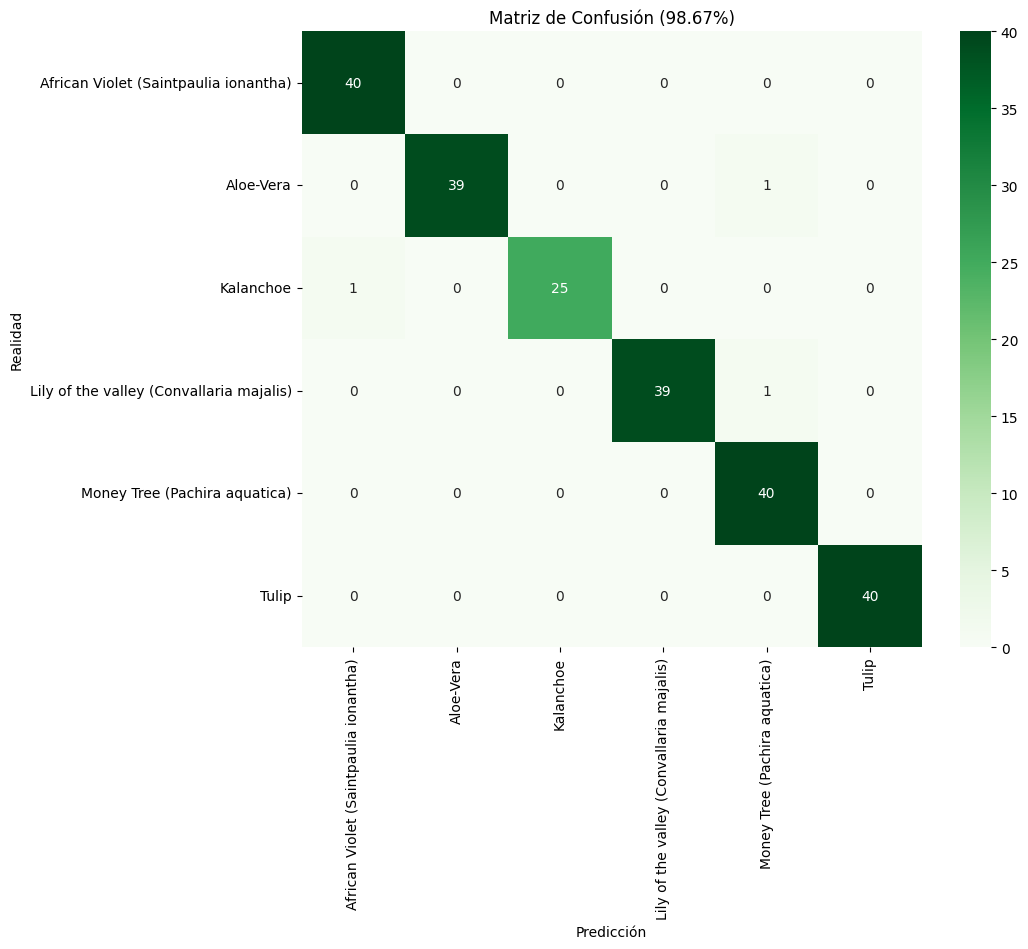

In [6]:
print("Cargando el mejor modelo entrenado...")
model.load_state_dict(torch.load('mejor_modelo_resnet50.pth'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

print("Evaluando conjunto de test...")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = np.mean(np.array(all_labels) == np.array(all_preds)) * 100
print(f"\nPRECISIÓN FINAL: {accuracy:.2f}%")

print("\n" + classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title(f'Matriz de Confusión ({accuracy:.2f}%)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

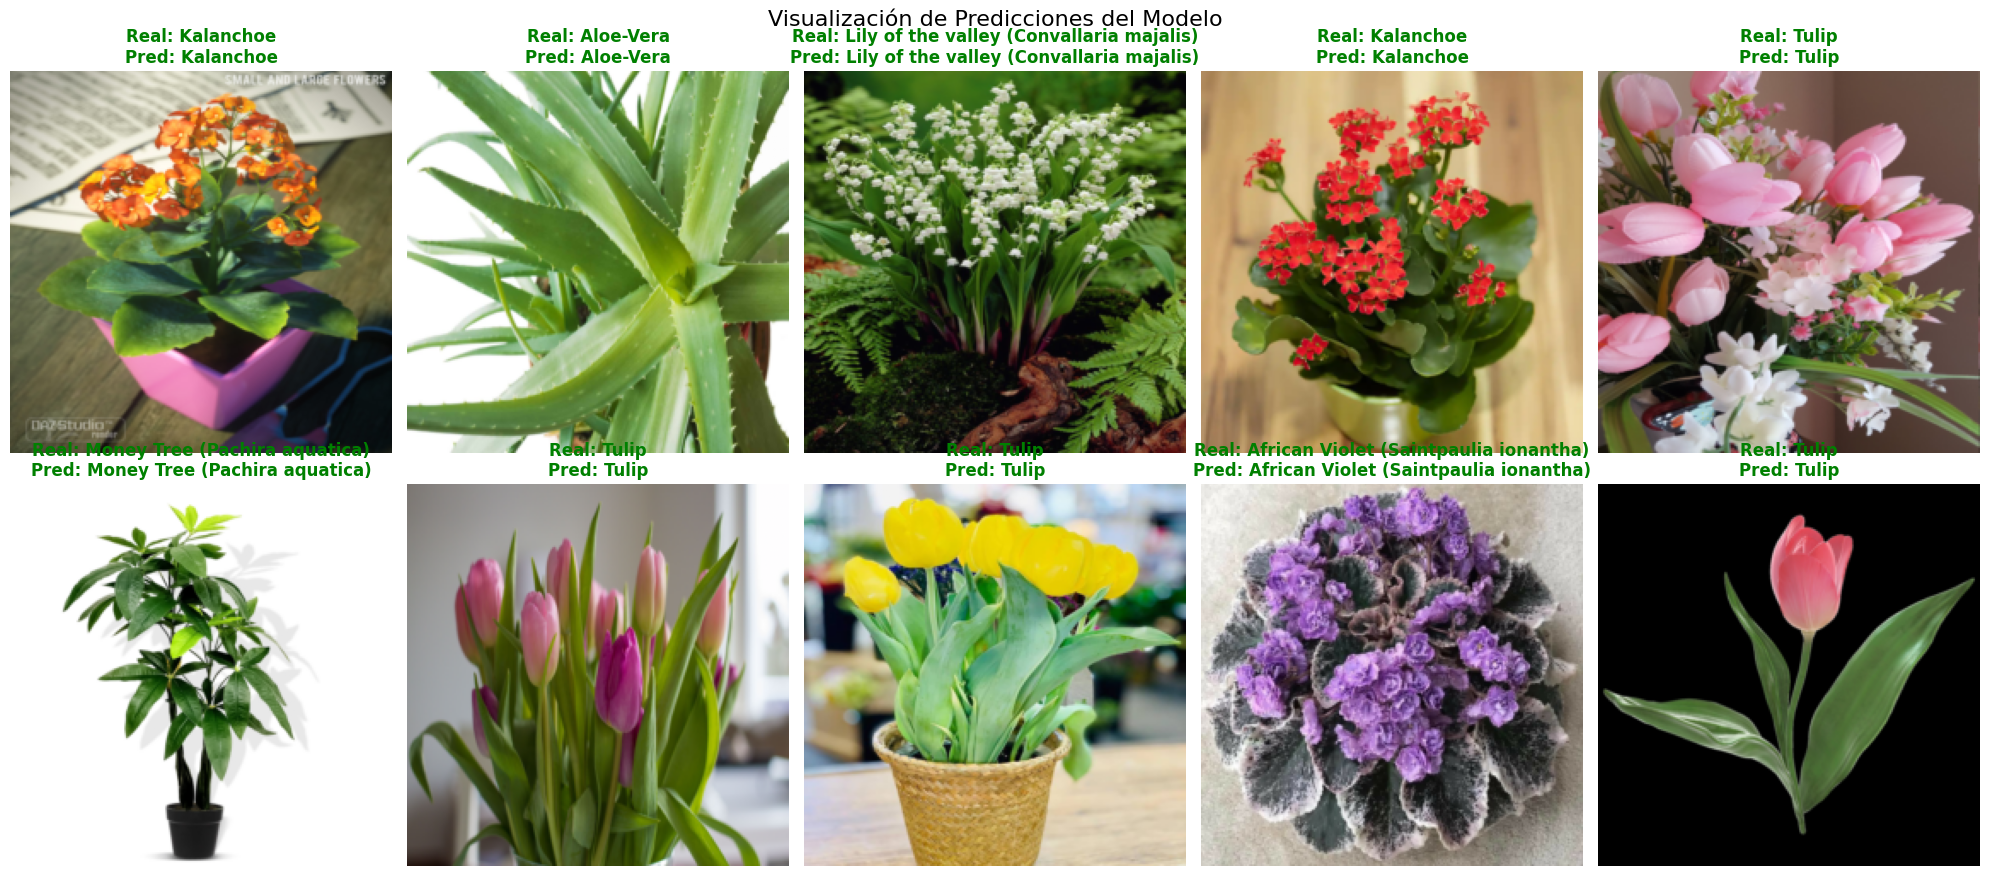

In [7]:
def denormalize(tensor):
    tensor = tensor.clone().detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

indices = random.sample(range(len(test_ds)), 10)

fig, axes = plt.subplots(2, 5, figsize=(20, 9))
axes = axes.flatten()

model.eval()

with torch.no_grad():
    for i, idx in enumerate(indices):
        img_tensor, label_idx = test_ds[idx]
        img_input = img_tensor.unsqueeze(0).to(device)
        
        output = model(img_input)
        _, pred_idx = torch.max(output, 1)
        
        true_name = classes[label_idx]
        pred_name = classes[pred_idx.item()]
        color = 'green' if pred_idx == label_idx else 'red'
        
        img_show = denormalize(img_tensor).permute(1, 2, 0).numpy()
        
        axes[i].imshow(img_show)
        axes[i].set_title(f"Real: {true_name}\nPred: {pred_name}", color=color, fontweight='bold')
        axes[i].axis('off')

plt.suptitle("Visualización de Predicciones del Modelo", fontsize=16)
plt.tight_layout()
plt.show()